In [2]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
data = pd.read_csv('train.txt')

In [9]:
print(data.shape)
data.describe().T

(8523, 12)


,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [11]:
data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [12]:
data['Item_Weight'].interpolate(inplace=True)
data['Item_Weight'].isnull().sum()

0

In [13]:
data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace=True)
data['Outlet_Size'].isnull().sum()

0

In [15]:
print(f'Number of unique values in "Estd. Year" is {data.Outlet_Establishment_Year.nunique()}')
print(data.Outlet_Establishment_Year.value_counts(dropna=False))
data.Outlet_Establishment_Year = data.Outlet_Establishment_Year.astype('object')

Number of unique values in "Estd. Year" is 9
1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64


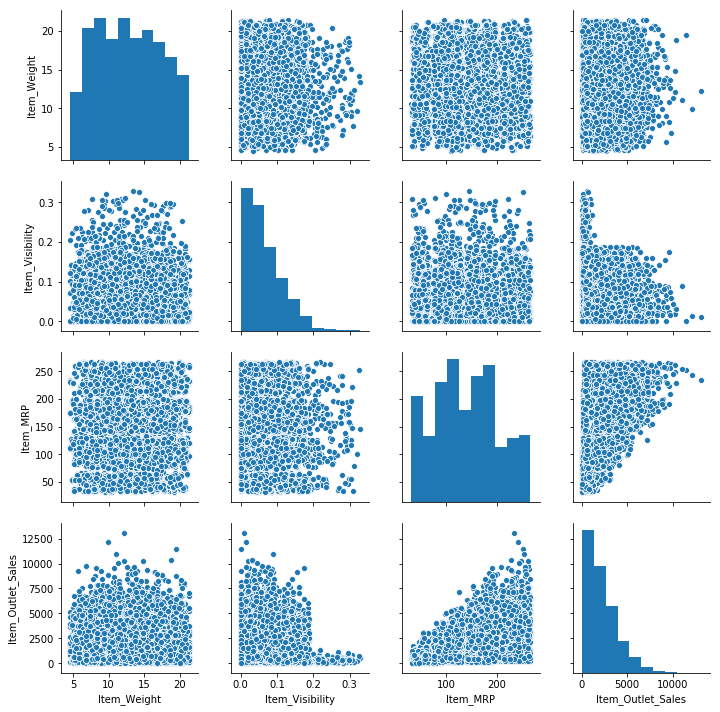

In [19]:
num_cols = [* data.select_dtypes(['int64', 'float64']).columns]
sns.pairplot(data[num_cols])

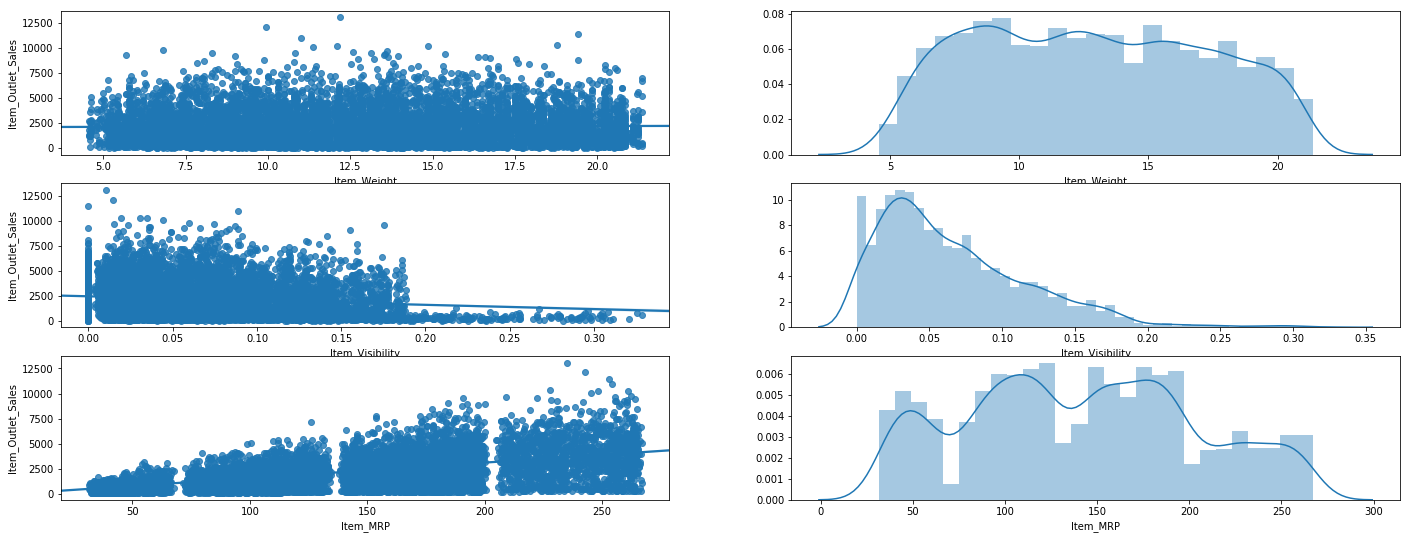

In [20]:
num_cols.remove('Item_Outlet_Sales')
count = 1
plt.figure(figsize = (24, 9))
for col in num_cols:
    plt.subplot(3, 2, count)
    sns.regplot(x = col, y = 'Item_Outlet_Sales', data = data)
    plt.xlabel(col)
    count += 1
    plt.subplot(3, 2, count)
    sns.distplot(data.loc[data[col].notnull(), col])
    count += 1

In [22]:
obj_cols = [ * data.select_dtypes('object').columns]

for col in obj_cols:
    if data[col].nunique() > 10:
        print(f'Number of unique values in {col} is {data[col].nunique()} so not printing values')
        print()
    else:
        print(f'Values in {col} are :\n{data[col].value_counts()}')
        print()

Number of unique values in Item_Identifier is 1559 so not printing values

Values in Item_Fat_Content are :
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Number of unique values in Item_Type is 16 so not printing values

Values in Outlet_Identifier are :
OUT027    935
OUT013    932
OUT046    930
OUT035    930
OUT049    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

Values in Outlet_Establishment_Year are :
1985    1463
1987     932
2004     930
1999     930
1997     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

Values in Outlet_Size are :
Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Values in Outlet_Location_Type are :
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Values in Outlet_Type are :
Supermarket Type1    5577
Groc

In [23]:
data['Item_Fat_Content'].value_counts(dropna=False)

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [24]:
data['Item_Fat_Content'].replace({'LF': "Low Fat", 'low fat': 'Low Fat', 'reg': 'Regular'}, inplace=True)
data['Item_Fat_Content'].value_counts(dropna=False)

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [40]:
print(data['Item_Identifier'].sample(10))
print(data['Item_Identifier'].str[:3].value_counts(dropna = False))
print(data['Item_Identifier'].str[:2].value_counts(dropna = False))

data['Item_Identifier'] = data['Item_Identifier'].str[:2]

2538    FDQ09
2822    FDZ19
7995    FDO20
1000    FDE33
6480    FDI02
3507    FDA02
5343    NCU06
6660    FDT01
8378    NCX05
2133    FDS57
Name: Item_Identifier, dtype: object
FDX    295
FDT    281
FDS    279
FDR    275
FDW    271
FDY    271
FDV    270
FDZ    264
FDU    263
FDA    245
FDB    245
FDQ    241
FDO    233
FDP    228
FDH    223
FDC    219
FDD    218
FDG    213
FDL    213
FDK    207
FDI    206
FDE    199
FDN    199
FDF    197
FDJ    194
FDM    176
NCO     93
NCN     88
NCM     82
NCP     81
      ... 
DRD     63
NCR     63
NCJ     62
NCS     59
NCE     59
NCX     59
NCB     58
NCY     56
NCZ     56
NCH     54
NCV     52
NCA     52
NCF     52
NCU     50
DRL     50
NCD     49
NCC     48
NCT     47
NCW     45
NCG     43
DRM     43
DRC     37
DRN     34
DRB     25
DRA     21
DRO     14
DRP     12
DRZ     11
DRQ      7
DRY      6
Name: Item_Identifier, Length: 71, dtype: int64
FD    6125
NC    1599
DR     799
Name: Item_Identifier, dtype: int64


In [41]:
data['Item_Fat_Content'] = np.where(data['Item_Identifier'] == 'NC', 'Non-edible', data['Item_Fat_Content'])

In [42]:
data.sample(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3769,FD,13.7400,Regular,0.029230,Breads,189.4556,OUT027,1985,Medium,Tier 3,Supermarket Type3,3567.3564
509,DR,15.0725,Low Fat,0.087855,Soft Drinks,95.9752,OUT019,1985,Small,Tier 1,Grocery Store,95.8752
7701,FD,9.6000,Low Fat,0.051572,Snack Foods,258.4620,OUT045,2002,Medium,Tier 2,Supermarket Type1,4673.9160
5355,FD,7.0500,Low Fat,0.084950,Snack Foods,109.7912,OUT035,2004,Small,Tier 2,Supermarket Type1,1091.9120
7063,FD,16.2250,Low Fat,0.092145,Breads,120.7098,OUT027,1985,Medium,Tier 3,Supermarket Type3,3735.8038
6027,FD,10.1950,Low Fat,0.041934,Snack Foods,44.6428,OUT035,2004,Small,Tier 2,Supermarket Type1,615.1992
8088,FD,18.2500,Regular,0.171524,Dairy,155.8630,OUT018,2009,Medium,Tier 3,Supermarket Type2,2346.9450
549,FD,9.5000,Regular,0.035206,Fruits and Vegetables,171.3448,OUT049,1999,Medium,Tier 1,Supermarket Type1,2386.2272
1941,NC,6.4200,Non-edible,0.207783,Household,262.2910,OUT019,1985,Small,Tier 1,Grocery Store,525.9820
6667,DR,15.2500,Low Fat,0.033737,Soft Drinks,56.6614,OUT027,1985,Medium,Tier 3,Supermarket Type3,607.8754


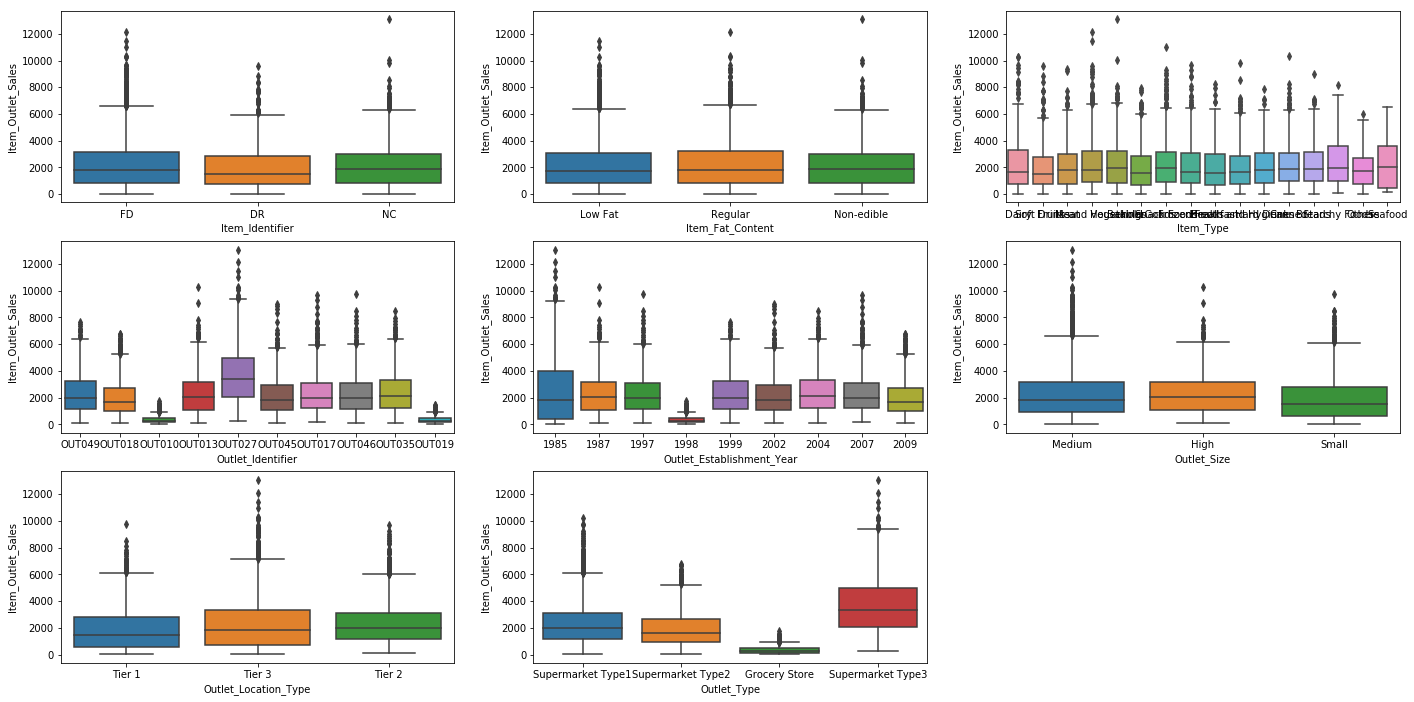

In [43]:
plt.figure(figsize = (24, 12))
for idx, col in enumerate(obj_cols):
    plt.subplot(3, 3, idx + 1)
    sns.boxplot(col, 'Item_Outlet_Sales', data = data)

In [44]:
df = pd.get_dummies(data, drop_first = True)
df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Identifier_FD,Item_Identifier_NC,Item_Fat_Content_Non-edible,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,3735.1380,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,443.4228,0,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,0
2,17.50,0.016760,141.6180,2097.2700,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,732.3800,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,8.93,0.000000,53.8614,994.7052,0,1,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [45]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,8523.0,12.831222,4.445074,4.555,9.000000,12.600000,16.600000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800
Item_Identifier_FD,8523.0,0.718644,0.449687,0.000,0.000000,1.000000,1.000000,1.000000
Item_Identifier_NC,8523.0,0.187610,0.390423,0.000,0.000000,0.000000,0.000000,1.000000
Item_Fat_Content_Non-edible,8523.0,0.187610,0.390423,0.000,0.000000,0.000000,0.000000,1.000000
Item_Fat_Content_Regular,8523.0,0.352693,0.477836,0.000,0.000000,0.000000,1.000000,1.000000
Item_Type_Breads,8523.0,0.029450,0.169073,0.000,0.000000,0.000000,0.000000,1.000000
Item_Type_Breakfast,8523.0,0.012906,0.112877,0.000,0.000000,0.000000,0.000000,1.000000


In [46]:
df['Non-Visible'] = np.where(df['Item_Visibility'] == 0, 1, 0)
df['Non-Visible'].value_counts(dropna = False)

0    7997
1     526
Name: Non-Visible, dtype: int64

In [47]:
df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Identifier_FD,Item_Identifier_NC,Item_Fat_Content_Non-edible,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Non-Visible
0,9.30,0.016047,249.8092,3735.1380,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,5.92,0.019278,48.2692,443.4228,0,0,0,1,0,0,...,0,1,1,0,0,1,0,1,0,0
2,17.50,0.016760,141.6180,2097.2700,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,19.20,0.000000,182.0950,732.3800,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
4,8.93,0.000000,53.8614,994.7052,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,0,1


In [48]:
X, y = df.drop('Item_Outlet_Sales', axis = 1), df.Item_Outlet_Sales

In [49]:
X.shape, y.shape

((8523, 47), (8523,))

In [50]:
y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [53]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, lr_pred)))

1113.9391846079557


In [55]:
rf = RandomForestRegressor(max_depth = 5)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, rf_pred)))

1073.406069120103


In [56]:
gbm = GradientBoostingRegressor(max_depth = 2)
gbm.fit(X_train, y_train)
gbm_pred = gbm.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, gbm_pred)))

1064.0813624375799


In [57]:
etr = ExtraTreesRegressor()
etr.fit(X_train, y_train)
etr_pred = etr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, etr_pred)))

1230.7916334398174


In [58]:
iso_forest = IsolationForest(contamination = 'auto', behaviour = 'New')
outliers = iso_forest.fit_predict(X, y)
pd.Series(outliers).value_counts(dropna=False)

 1    8294
-1     229
dtype: int64

In [59]:
out_bool = outliers == 1
X_new, y_new = X[out_bool], y[out_bool]

In [60]:
X_new.shape, y_new.shape

((8294, 47), (8294,))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state = 123, test_size = 0.2)

In [63]:
model_list = [LinearRegression(), 
              RandomForestRegressor(max_depth = 5), 
              GradientBoostingRegressor(max_depth = 2),]
for model in model_list:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(np.sqrt(mean_squared_error(y_test, pred)))

1109.3059211483678
1070.8809196531938
1068.6869428206637
